In [2]:
'''
Notebook to specifically study correlations between ELG targets and Galactic foregrounds

Much of this made possible and copied from script shared by Anand Raichoor

Run in Python 3; install pymangle, fitsio, healpy locally: pip install --user fitsio; pip install --user healpy; git clone https://github.com/esheldon/pymangle...

'''

import fitsio
import numpy as np
#from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap
import astropy.io.fits as fits
import glob
import os
import healpy as hp
from matplotlib import pyplot as plt


In [3]:
#Some information is in pixelized map
#get nside and nest from header
pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr        = fits.getheader(pixfn,1)
nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
print(fits.open(pixfn)[1].columns.names)
hpq = fitsio.read(pixfn)

['HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY']


In [4]:
#get MC efficiency
mcf = fitsio.read(os.getenv('SCRATCH')+'/ELGMCeffHSCHP.fits')
mmc = np.mean(mcf['EFF'])
mcl = np.zeros(12*nside*nside)
for i in range(0,len(mcf)):
    pix = mcf['HPXPIXEL'][i]
    mcl[pix] = mcf['EFF'][i]/mmc

In [5]:
#ELGs were saved here
elgf = os.getenv('SCRATCH')+'/ELGtargetinfo.fits'

In [6]:
#for healpix
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180.,ra*np.pi/180.

In [7]:
#read in ELGs, put them into healpix
felg = fitsio.read(elgf)
dth,dphi = radec2thphi(felg['RA'],felg['DEC'])
dpix = hp.ang2pix(nside,dth,dphi,nest)

In [8]:
lelg = len(felg)
print(lelg)

47256516


In [9]:
#full random file is available, easy to read some limited number; take 1.5x ELG to start with
rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(int(1.5*lelg))
                  )
rall_header = fitsio.read_header('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',ext=1)

In [10]:
#cut randoms to ELG footprint
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))
relg = rall[keepelg]

67762950
64567641


In [11]:
#write out randoms
#fitsio.write(os.getenv('SCRATCH')+'/ELGrandoms.fits',relg,overwrite=True)

In [11]:
#put randoms into healpix
rth,rphi = radec2thphi(relg['RA'],relg['DEC'])
rpix = hp.ang2pix(nside,rth,rphi,nest=nest)

In [17]:
#let's define split into bmzls, DECaLS North, DECaLS South (Anand has tools to make distinct DES region as well)
#one function to do directly, the other just for the indices

print(np.unique(felg['PHOTSYS']))
#bmzls = b'N' #if in desi environment
bmzls = 'N' #if in Python 3; why the difference? Maybe version of fitsio?

def splitcat(cat):
    NN = cat['PHOTSYS'] == bmzls
    d1 = (cat['PHOTSYS'] != bmzls) & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return cat[NN],cat[d1],cat[d2]

def splitcat_ind(cat):
    NN = cat['PHOTSYS'] == bmzls
    d1 = (cat['PHOTSYS'] != bmzls) & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return NN,d1,d2

In [18]:
#indices for split
dbml,ddnl,ddsl = splitcat_ind(felg)
rbml,rdnl,rdsl = splitcat_ind(relg)
print(len(felg[dbml]),len(felg[ddnl]),len(felg[ddsl]))

12726178 14094848 13407623


['N' 'S']


In [19]:
#put into full sky maps (probably not necessary but easier to keep straight down the line)
pixlrbm = np.zeros(12*nside*nside)
pixlgbm = np.zeros(12*nside*nside)
pixlrdn = np.zeros(12*nside*nside)
pixlgdn = np.zeros(12*nside*nside)
pixlrds = np.zeros(12*nside*nside)
pixlgds = np.zeros(12*nside*nside)

for pix in rpix[rbml]:
    pixlrbm[pix] += 1.
print('randoms done')
for pix in dpix[dbml]:
    pixlgbm[pix] += 1.

for pix in rpix[rdnl]:
    pixlrdn[pix] += 1.
print('randoms done')
for pix in dpix[ddnl]:
    pixlgdn[pix] += 1.
    
for pix in rpix[rdsl]:
    pixlrds[pix] += 1.
print('randoms done')
for pix in dpix[ddsl]:
    pixlgds[pix] += 1.
    

randoms done
randoms done
randoms done


In [20]:
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*hpq['STARDENS']+b)

In [21]:
print(len(pixlgds))

786432


In [22]:
def plotvshp(r1,d1,sys,rng,gdzm=20,ebvm=0.15,useMCeff=True,correctstar=False,title='',effac=1.,south=True):
    w = hpq['GALDEPTH_Z'] > gdzm
    w &= hpq['EBV'] < ebvm
    if useMCeff:
        w &= mcl > 0
    if sys != 'gdc' and sys != 'rdc' and sys != 'zdc':
        sm = hpq[w][sys]
    else:
        if sys == 'gdc':
            print('g depth, extinction corrected')
            sm = hpq[w]['GALDEPTH_G']*np.exp(-3.214*hpq[w]['EBV'])
        if sys == 'rdc':
            sm = hpq[w]['GALDEPTH_R']*np.exp(-2.165*hpq[w]['EBV'])
        if sys == 'zdc':
            sm = hpq[w]['GALDEPTH_Z']*np.exp(-1.211*hpq[w]['EBV'])
    ds = np.ones(len(d1))
    if correctstar:
        ds = ws
    dmc = np.ones(len(d1))
    if useMCeff:
        dmc = mcl**effac
    hd1 = np.histogram(sm,weights=d1[w]*ds[w]/dmc[w],range=rng)
    hdnoc = np.histogram(sm,weights=d1[w],bins=hd1[1],range=rng)
    #print(hd1)
    hr1 = np.histogram(sm,weights=r1[w],bins=hd1[1],range=rng)
    #print(hr1)
    xl = []
    for i in range(0,len(hd1[0])):
        xl.append((hd1[1][i]+hd1[1][i+1])/2.)
    plt.errorbar(xl,hd1[0]/hr1[0]/(sum(d1[w]*ds[w]/dmc[w])/sum(r1[w])),np.sqrt(hd1[0])/hr1[0]/(lelg/len(relg)),fmt='ko')
    if useMCeff:
        plt.plot(xl,hdnoc[0]/hr1[0]/(sum(d1[w])/sum(r1[w])),'k--')
    print(hd1[0]/hr1[0]/(sum(d1[w]*ds[w]/dmc[w])/sum(r1[w])))
    #plt.title(str(mp)+reg)
    plt.plot(xl,np.ones(len(xl)),'k:')
    plt.ylabel('relative density')
    plt.xlabel(sys)
    plt.ylim(0.7,1.3)
    plt.title(title)
    plt.show()    

[1.00834509 0.99913033 1.00091741 0.98982195 0.96729787 0.9540792
 0.98379748 0.9688327  0.90180147 0.85811363]


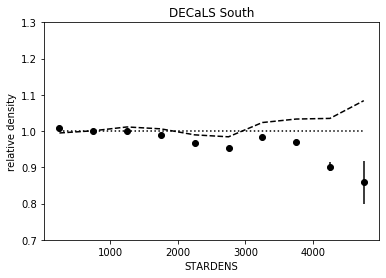

[0.98984774 1.00755547 1.00659933 0.98833818 0.98862582 0.98498148
 1.00108308 1.00904531 1.04607738 1.07255377]


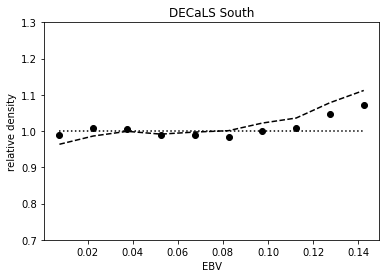

g depth, extinction corrected
[0.9394853  0.99777144 0.99723371 1.01056154 1.00544017 0.98147096
 0.99293003 1.00725467 1.02683659 1.02046736]


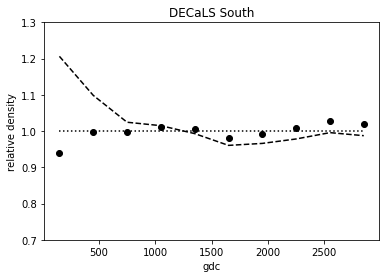

[1.02904381 1.02376298 1.01416121 1.00730443 1.01374736 1.02617298
 0.99313469 0.96955143 0.98103358 0.97284858]


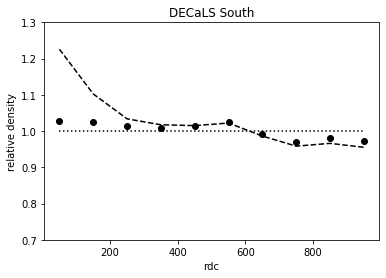

[1.00582793 1.00350541 1.0018523  1.00902478 1.010475   0.99637676
 0.98793093 0.98254012 0.9615657  0.94416137]


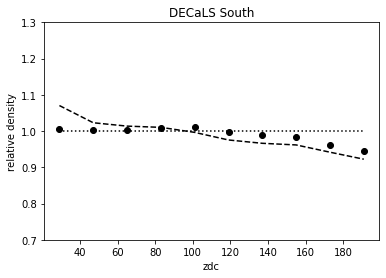

In [23]:
title = 'DECaLS South'
effac=2.
plotvshp(pixlrds,pixlgds,'STARDENS',(0,0.5e4),title=title,effac=effac)
plotvshp(pixlrds,pixlgds,'EBV',(0,0.15),title=title,effac=effac)
plotvshp(pixlrds,pixlgds,'gdc',(0,3000),title=title,effac=effac)
plotvshp(pixlrds,pixlgds,'rdc',(0,1000),title=title,effac=effac)
plotvshp(pixlrds,pixlgds,'zdc',(20,200),title=title,effac=effac)

[1.0063207  1.00139193 0.98488653 0.9952049  0.98858947 0.99068387
 0.98903376 0.98099173 0.90551623 0.90920492]


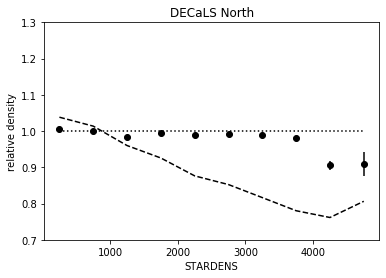

[0.97742883 1.00944357 1.01480708 0.99328115 0.96149641 0.9508606
 0.92902697 0.91680285 0.92628948 0.92531965]


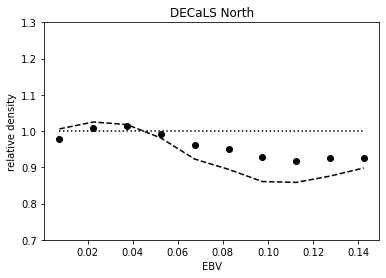

g depth, extinction corrected


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


[0.90643692 1.01001843 0.99705196 1.00372971 1.00100028 0.99705965
 0.98955952 1.04473136        nan        nan]


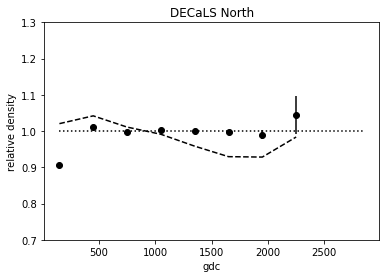

[1.0154483  1.05769024 1.0104839  0.99658748 0.9803229  0.95290728
 0.95287227 0.95551865 0.96491766 0.91701352]


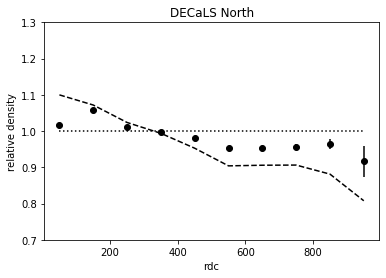

[0.98753356 1.00185855 0.99545082 1.00735374 1.00843812 1.00403044
 1.03464683 1.06863124 1.08847196 1.01625369]


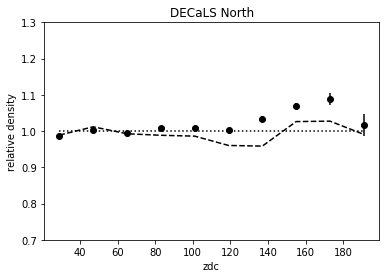

In [24]:
title = 'DECaLS North'
effac=2.
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*hpq['STARDENS']+b)
cs = True

plotvshp(pixlrdn,pixlgdn,'STARDENS',(0,0.5e4),title=title,effac=effac,correctstar=cs)
plotvshp(pixlrdn,pixlgdn,'EBV',(0,0.15),title=title,effac=effac,correctstar=cs)
plotvshp(pixlrdn,pixlgdn,'gdc',(0,3000),title=title,effac=effac,correctstar=cs)
plotvshp(pixlrdn,pixlgdn,'rdc',(0,1000),title=title,effac=effac,correctstar=cs)
plotvshp(pixlrdn,pixlgdn,'zdc',(20,200),title=title,effac=effac,correctstar=cs)

[1.03629782 0.99252015 0.95940507 0.9756098  0.97685887 0.98111145
 0.96777165 0.97545035 0.9563601  1.02609734]


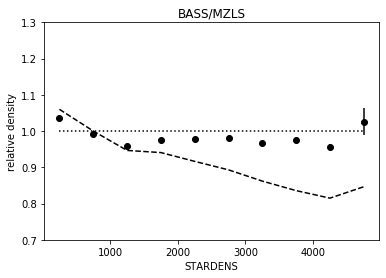

[1.0316863  1.02972062 0.98926607 0.9726009  0.92519047 0.89100629
 0.87613763 0.84948451 0.85067964 0.85249831]


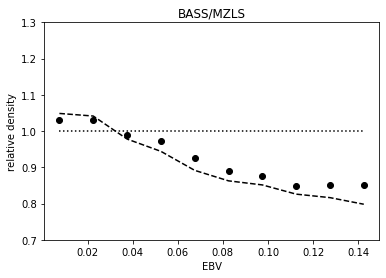

g depth, extinction corrected


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


[1.08337265 0.98782457 1.00249528 1.01066131 1.03048049 1.01498064
 1.06489199 1.34160162 0.79861267        nan]


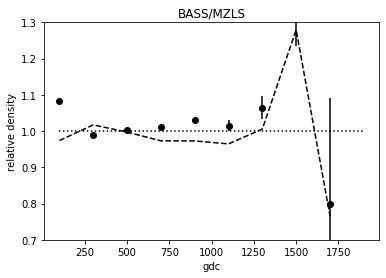

[1.00287625 1.00156496 0.98311111 0.94074111 0.91615748 1.43019421
 1.53451924        nan        nan        nan]


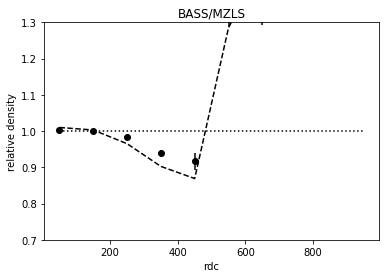

[0.95789458 0.98887917 1.00888461 1.0161067  1.00432513 1.00889091
 1.01748217 1.13632554 1.09434231        nan]


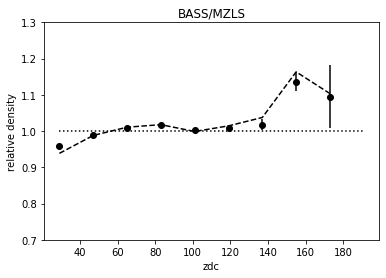

In [26]:
title = 'BASS/MZLS'
effac=1.
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*hpq['STARDENS']+b)
cs = True

plotvshp(pixlrbm,pixlgbm,'STARDENS',(0,0.5e4),title=title,effac=effac,correctstar=cs)
plotvshp(pixlrbm,pixlgbm,'EBV',(0,0.15),title=title,effac=effac,correctstar=cs)
plotvshp(pixlrbm,pixlgbm,'gdc',(0,2000),title=title,effac=effac,correctstar=cs)
plotvshp(pixlrbm,pixlgbm,'rdc',(0,1000),title=title,effac=effac,correctstar=cs)
plotvshp(pixlrbm,pixlgbm,'zdc',(20,200),title=title,effac=effac,correctstar=cs)

In [28]:
'''
Below here, directly use data/randoms
'''

'\nBelow here, directly use data/randoms\n'

In [27]:
#Open files with grids for efficiency and define function to interpolate them (to be improved)
grids = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffgridsouth.dat').transpose()
#grids[3] = grids[3]
gridn = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffgridnorth.dat').transpose()
#print(np.mean(gridn[3]))
#gridn[3] = gridn[3]/np.mean(gridn[3])
def interpeff(gsig,rsig,zsig,south=True):
    md = 0
    xg = 0.15
    #if gsig > xg:
    #    gsig = .99*xg
    xr = 0.15
    #if rsig > xr:
    #    rsig = 0.99*xr
    xz = 0.4
    #if zsig > xz:
    #    zsig = 0.99*xz
    ngp = 30
    if south:
        grid = grids
    else:
        grid = gridn
    i = (ngp*gsig/(xg-md)).astype(int)
    j = (ngp*rsig/(xr-md)).astype(int)
    k = (ngp*zsig/(xz-md)).astype(int)
    ind = (i*ngp**2.+j*ngp+k).astype(int)
    #print(i,j,k,ind)
    #print(grid[0][ind],grid[1][ind],grid[2][ind])
    #print(grid[0][ind-1],grid[1][ind-1],grid[2][ind-1])
    #print(grid[0][ind+1],grid[1][ind+1],grid[2][ind+1])
    return grid[3][ind]
#print(interpeff([0.0],[0.0],[0.0],south=False))   
#print(interpeff(0.0,0.0,0.0,south=True))
#print(0.1/.4)
#print(0.4/30.)
#grid[2][0]

In [29]:
#Get depth values that match those used for efficiency grids
depth_keyword="PSFDEPTH"
R_G=3.214 # http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients
R_R=2.165
R_Z=1.211

gsigmad=1./np.sqrt(felg[depth_keyword+"_G"])
rsigmad=1./np.sqrt(felg[depth_keyword+"_R"])
zsigmad=1./np.sqrt(felg[depth_keyword+"_Z"])
gsig = gsigmad*10**(0.4*R_G*felg["EBV"])
w = gsig >= 0.15
gsig[w] = 0.99*0.15
rsig = rsigmad*10**(0.4*R_R*felg["EBV"])
w = rsig >= 0.15
rsig[w] = 0.99*0.15
zsig = zsigmad*10**(0.4*R_Z*felg["EBV"])
w = zsig >= 0.4
zsig[w] = 0.99*0.4


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [30]:
print(min(gsig),max(gsig))
effsouthl = interpeff(gsig,rsig,zsig,south=True)

0.011088011 0.14999883


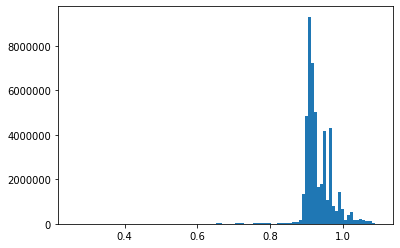

In [31]:
effnorthl = interpeff(gsig,rsig,zsig,south=False)
plt.hist(effnorthl,bins=100)
plt.show()

0.9651708193053623


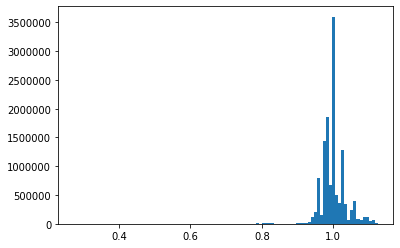

In [32]:
effbm = effnorthl[dbml]
print(np.mean(effbm))
effbm = effbm/np.mean(effbm)
plt.hist(effbm,bins=100)
plt.show()

1.0254885421358475


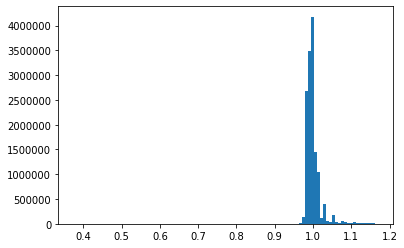

1.0199224461437835


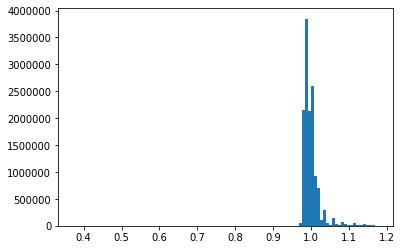

In [33]:
effdn = effsouthl[ddnl]
print(np.mean(effdn))
effdn = effdn/np.mean(effdn)
plt.hist(effdn,bins=100)
plt.show()
#plt.scatter(felg[dbml]['RA'],felg[dbml]['DEC'],c=effbm)
#plt.colorbar()
#plt.show()
effds = effsouthl[ddsl]
print(np.mean(effds))
effds = effds/np.mean(effds)
plt.hist(effds,bins=100)
plt.show()


In [34]:
stardensg = np.zeros(len(felg))
print(len(felg),len(dpix))
for i in range(0,len(dpix)):
    if i%1000000==0 : print(i)
    pix = dpix[i]
    stardensg[i] = hpq['STARDENS'][pix]

47256516 47256516
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000


In [35]:
stardensr = np.zeros(len(relg))
print(len(relg),len(rpix))
for i in range(0,len(rpix)):
    if i%1000000==0 : print(i)
    pix = rpix[i]
    stardensr[i] = hpq['STARDENS'][pix]    

64567641 64567641
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000


In [36]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-3.214*felg[dbml]['EBV']),weights=1./effbm*ws,range=(0,2000))
hr1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-3.214*relg[rbml]['EBV']),bins=hg1[1])
#no correction
hgn1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-3.214*felg[dbml]['EBV']),bins=hg1[1])
hrn1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-3.214*relg[rbml]['EBV']),bins=hg1[1])

In [37]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)
hg2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-3.214*felg[ddnl]['EBV']),weights=1./effdn**2.*ws,range=(0,3000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-3.214*relg[rdnl]['EBV']),bins=hg2[1])

hgn2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-3.214*felg[ddnl]['EBV']),bins=hg2[1])
hrn2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-3.214*relg[rdnl]['EBV']),bins=hg2[1])

In [38]:
#DECaLS S
#no strong relation with stellar density
hg3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsl]['EBV']),weights=1./effds**2.,range=(0,2000))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsl]['EBV']),bins=hg3[1])

hgn3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsl]['EBV']),bins=hg3[1])
hrn3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsl]['EBV']),bins=hg3[1])

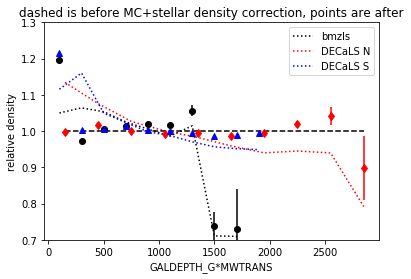

In [41]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_G*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [42]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_R']*np.exp(-1.*R_R*felg[dbml]['EBV']),weights=1./effbm*ws,range=(0,500))
hr1 = np.histogram(relg[rbml]['GALDEPTH_R']*np.exp(-1.*R_R*relg[rbml]['EBV']),bins=hg1[1])
hgn1 = np.histogram(felg[dbml]['GALDEPTH_R']*np.exp(-1.*R_R*felg[dbml]['EBV']),bins=hg1[1])


In [43]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(felg[ddnl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddnl]['EBV']),weights=1./effdn**2.*ws,range=(0,1000))
hgn2 = np.histogram(felg[ddnl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddnl]['EBV']),bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['GALDEPTH_R']*np.exp(-1.*R_R*relg[rdnl]['EBV']),bins=hg2[1])

In [44]:
#DECaLS S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddsl]['EBV']),weights=1./effds**2.,range=(0,1000))
hgn3 = np.histogram(felg[ddsl]['GALDEPTH_R']*np.exp(-1.*R_R*felg[ddsl]['EBV']),bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['GALDEPTH_R']*np.exp(-1.*R_R*relg[rdsl]['EBV']),bins=hg3[1])

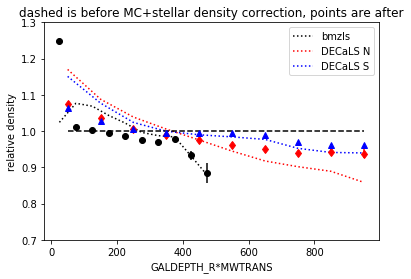

In [46]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_R*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [47]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[dbml]['EBV']),weights=1./effbm*ws,range=(0,200))
hgn1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[dbml]['EBV']),bins=hg1[1])
hr1 = np.histogram(relg[rbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rbml]['EBV']),bins=hg1[1])

In [48]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddnl]['EBV']),weights=1./effdn**2.*ws,range=(0,200))
hgn2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddnl]['EBV']),bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rdnl]['EBV']),bins=hg2[1])

In [49]:
#DECaLS S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-1.*R_R*felg[ddsl]['EBV']),weights=1./effds**2.,range=(0,200))
hgn3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-1.*R_R*felg[ddsl]['EBV']),bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['GALDEPTH_Z']*np.exp(-1.*R_R*relg[rdsl]['EBV']),bins=hg3[1])

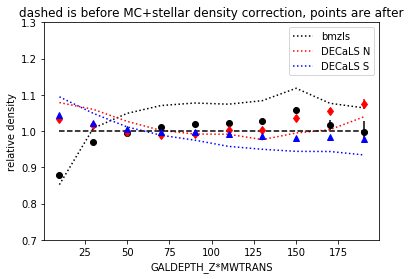

In [50]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_Z*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [51]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(stardensg[dbml],weights=1./effbm*ws,range=(0,5000))
hgn1 = np.histogram(stardensg[dbml],bins=hg1[1])
hr1 = np.histogram(stardensr[rbml],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(stardensg[ddnl],weights=1./effdn**2.*ws,range=(0,5000))
hgn2 = np.histogram(stardensg[ddnl],bins=hg2[1])
hr2 = np.histogram(stardensr[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(stardensg[ddsl],weights=1./effds**2.,range=(0,5000))
hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr3 = np.histogram(stardensr[rdsl],bins=hg3[1])

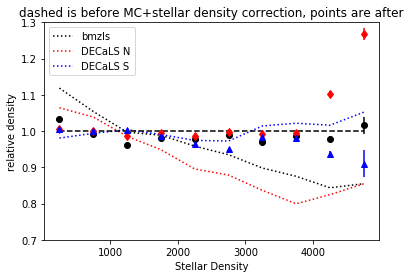

In [53]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('Stellar Density')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [54]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['EBV'],weights=1./effbm*ws,range=(0,0.15))
hgn1 = np.histogram(felg[dbml]['EBV'],bins=hg1[1])
hr1 = np.histogram(relg[rbml]['EBV'],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(felg[ddnl]['EBV'],weights=1./effdn**2.*ws,range=(0,0.15))
hgn2 = np.histogram(felg[ddnl]['EBV'],bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['EBV'],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(felg[ddsl]['EBV'],weights=1./effds**2.,range=(0,0.15))
hgn3 = np.histogram(felg[ddsl]['EBV'],bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['EBV'],bins=hg3[1])

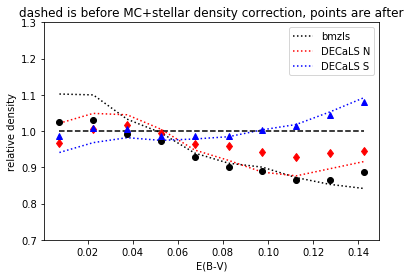

In [56]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('E(B-V)')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [57]:
nh1 = fits.open('NHI_HPX.fits.gz')[1].data['NHI']

In [58]:
#make data column
thphi = radec2thphi(felg['RA'],felg['DEC'])
r = hp.Rotator(coord=['C','G'],deg=False)
thphiG = r(thphi[0],thphi[1])
pixhg = hp.ang2pix(1024,thphiG[0],thphiG[1])
h1g = np.zeros(len(felg))
for i in range(0,len(pixhg)):
    h1g[i] = np.log(nh1[pixhg[i]])
    if i%1000000==0 : print(i)

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000


In [59]:
#make random column
thphi = radec2thphi(relg['RA'],relg['DEC'])
r = hp.Rotator(coord=['C','G'],deg=False)
thphiG = r(thphi[0],thphi[1])
pixhg = hp.ang2pix(1024,thphiG[0],thphiG[1])
h1r = np.zeros(len(relg))
for i in range(0,len(pixhg)):
    h1r[i] = np.log(nh1[pixhg[i]])
    if i%1000000==0 : print(i)

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000


In [60]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(h1g[dbml],weights=1./effbm*ws)
hgn1 = np.histogram(h1g[dbml],bins=hg1[1])
hr1 = np.histogram(h1r[rbml],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(h1g[ddnl],weights=1./effdn**2.*ws)
hgn2 = np.histogram(h1g[ddnl],bins=hg2[1])
hr2 = np.histogram(h1r[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(h1g[ddsl],weights=1./effds**2.)
hgn3 = np.histogram(h1g[ddsl],bins=hg3[1])
hr3 = np.histogram(h1r[rdsl],bins=hg3[1])

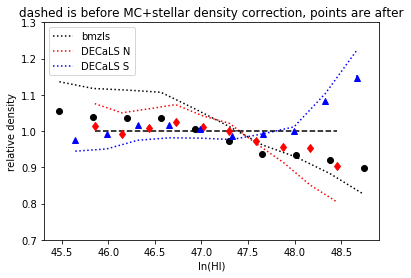

In [61]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('ln(HI)')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

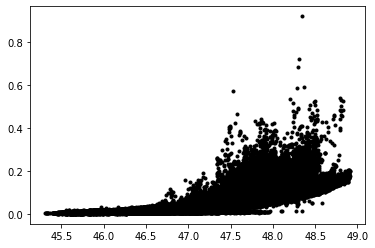

In [62]:
a = np.random.rand(len(relg))
w = a < 0.01
plt.plot(h1r[w],relg[w]['EBV'],'.k')
plt.show()

In [63]:
a,b = np.histogram(h1r,weights=relg['EBV'])
c,d = np.histogram(h1r,bins=b)
print(a)
print(c)


[6.70024597e+02 2.02695586e+04 1.11988445e+05 2.41894156e+05
 3.42473594e+05 5.88525938e+05 7.55287500e+05 4.73316500e+05
 1.13679469e+05 3.10282480e+04]
[   91427  2069447  8104081 11966951 11801914 13830959 11109112  4599702
   789186   204862]


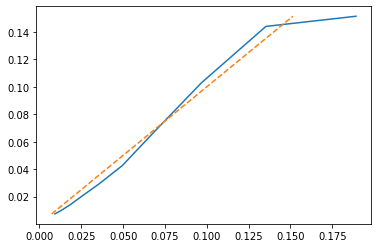

In [64]:
plt.plot(0.008*np.exp(np.array(xl3)-45.5),(a/c))
plt.plot(a/c,a/c,'--')
plt.show()

In [65]:
dhg = felg['EBV']-0.008*np.exp(h1g-45.5)

In [66]:
dhr = relg['EBV']-0.008*np.exp(h1r-45.5)

In [67]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(dhg[dbml],weights=1./effbm*ws,range=(-0.1,.15))
hgn1 = np.histogram(dhg[dbml],bins=hg1[1])
hr1 = np.histogram(dhr[rbml],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(dhg[ddnl],weights=1./effdn**2.*ws,range=(-0.1,.15))
hgn2 = np.histogram(dhg[ddnl],bins=hg2[1])
hr2 = np.histogram(dhr[rdnl],bins=hg2[1])

#DECaLS S
hg3 = np.histogram(dhg[ddsl],weights=1./effds**2.,range=(-0.1,.15))
hgn3 = np.histogram(dhg[ddsl],bins=hg3[1])
hr3 = np.histogram(dhr[rdsl],bins=hg3[1])

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


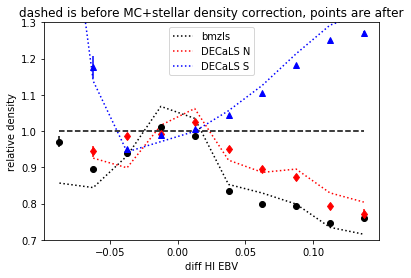

In [68]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('diff HI EBV')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

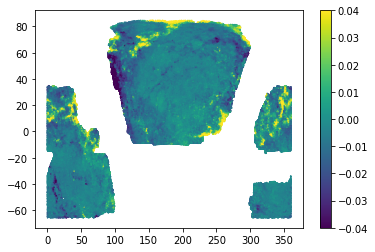

In [69]:
plt.scatter(relg[w]['RA'],relg[w]['DEC'],c=dhr[w],s=.1,vmax=0.04,vmin=-0.04)
plt.colorbar()
plt.show()

In [70]:
wr = abs(dhr) > 0.02
wg = abs(dhg) > 0.02
print(len(relg[wr])/len(relg))
print(len(felg[wg])/len(felg))

0.08020728215856608
0.07749707997940432


In [71]:
#bmzls
w1g = ~wg & dbml
w1r = ~wr & rbml
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[w1g]+b)
wsn = 1./(slp*stardensg[dbml]+b)
effbmw = effnorthl[w1g]
hg1 = np.histogram(felg[w1g]['EBV'],weights=1./effbmw*ws,range=(0,0.15))
hgn1 = np.histogram(felg[dbml]['EBV'],bins=hg1[1],weights=1./effbm*wsn)
hrn1 = np.histogram(relg[rbml]['EBV'],bins=hg1[1])
hr1 = np.histogram(relg[w1r]['EBV'],bins=hg1[1])
#DECaLS N
slp = -0.35/4000.
b = 1.1
w1g = ~wg & ddnl
w1r = ~wr & rdnl
ws = 1./(slp*stardensg[w1g]+b)
wsn = 1./(slp*stardensg[ddnl]+b)
effdnw = effsouthl[w1g]
hg2 = np.histogram(felg[w1g]['EBV'],weights=1./effdnw**2.*ws,range=(0,0.15))
hgn2 = np.histogram(felg[ddnl]['EBV'],bins=hg2[1],weights=1./effdn**2.*wsn)
hrn2 = np.histogram(relg[rdnl]['EBV'],bins=hg2[1])
hr2 = np.histogram(relg[w1r]['EBV'],bins=hg2[1])

#DECaLS S
w1g = ~wg & ddsl
w1r = ~wr & rdsl
effdsw = effsouthl[w1g]
hg3 = np.histogram(felg[w1g]['EBV'],weights=1./effdsw**2.,range=(0,0.15))
hgn3 = np.histogram(felg[ddsl]['EBV'],bins=hg3[1],weights=1./effds**2.)
hrn3 = np.histogram(relg[rdsl]['EBV'],bins=hg3[1])
hr3 = np.histogram(relg[w1r]['EBV'],bins=hg3[1])

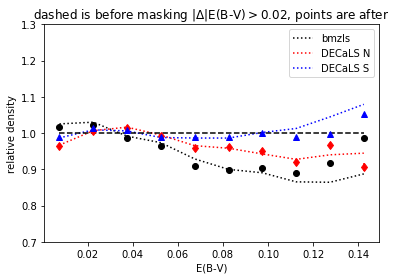

In [74]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0]) 
norm1n = sum(hgn1[0])/sum(hrn1[0]) 
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hrn1[0]/norm1n,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
norm2n = sum(hgn2[0])/sum(hrn2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hrn2[0]/norm2n,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
norm3n = sum(hgn3[0])/sum(hrn3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hrn3[0]/norm3n,'b:')
plt.ylim(.7,1.3)
plt.xlabel('E(B-V)')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.title(r'dashed is before masking |$\Delta$|E(B-V)$>0.02$, points are after')
plt.show()

In [ ]:
'''
Divide DECaLS S into DES and non-DES
'''

In [75]:
import pymangle
desply ='/global/cscratch1/sd/raichoor/desits/des.ply'
mng       = pymangle.mangle.Mangle(desply)

In [76]:
polyidd = mng.polyid(felg['RA'],felg['DEC'])
isdesd = polyidd != -1

In [77]:
polyidr = mng.polyid(relg['RA'],relg['DEC'])
isdesr = polyidr != -1

In [79]:
ddsdl = ddsl & isdesd

In [80]:
ddsndl = ddsl & ~isdesd

In [81]:
rdsdl = rdsl & isdesr
rdsndl = rdsl & ~isdesr

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


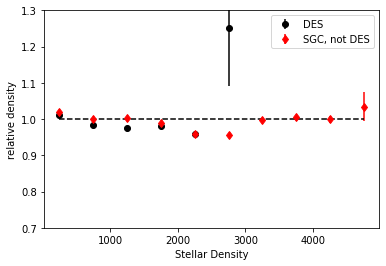

In [84]:
#DECaLS SGC DES
#hg3 = np.histogram(stardensg[ddsl],weights=1./effds**2.,range=(0,5000))
hg1 = np.histogram(stardensg[ddsdl],range=(0,5000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr1 = np.histogram(stardensr[rdsdl],bins=hg1[1])

#DECaLS SGC not DES
#hg3 = np.histogram(stardensg[ddsl],weights=1./effds**2.,range=(0,5000))
hg2 = np.histogram(stardensg[ddsndl],range=(0,5000))
#hgn3 = np.histogram(stardensg[ddsl],bins=hg3[1])
hr2 = np.histogram(stardensr[rdsndl],bins=hg2[1])

xl1 = []
xl2 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
#plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
#plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
plt.ylim(.7,1.3)
plt.xlabel('Stellar Density')
plt.ylabel('relative density')
plt.legend((['DES','SGC, not DES']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
#plt.title('dashed is before MC+stellar density correction, points are after')
plt.show()

In [ ]:
'''
Above results didn't quite work at low depth; checking what happens when snr requirements are ignored in the MC
Results are gone, but they basically show that removing the snr requirements makes things worse
'''
grids = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffnosnrgridsouth.dat').transpose()
#grids[3] = grids[3]
gridn = np.loadtxt(os.getenv('SCRATCH')+'/ELGeffnosnrgridnorth.dat').transpose()
effsouthlno = interpeff(gsig,rsig,zsig,south=True)
effnorthlno = interpeff(gsig,rsig,zsig,south=False)

In [ ]:
effbmno = effnorthlno[dbml]
print(np.mean(effbmno))
effbmno = effbmno/np.mean(effbmno)
plt.hist(effbmno,bins=100)
plt.show()

In [ ]:
effdnno = effsouthlno[ddnl]
print(np.mean(effdnno))
effdnno = effdnno/np.mean(effdnno)
plt.hist(effdnno,bins=100)
plt.show()
#plt.scatter(felg[dbml]['RA'],felg[dbml]['DEC'],c=effbm)
#plt.colorbar()
#plt.show()
effdsno = effsouthlno[ddsl]
print(np.mean(effdsno))
effdsno = effdsno/np.mean(effdsno)
plt.hist(effdsno,bins=100)
plt.show()


In [ ]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[dbml]['EBV']),weights=1./effbmno*ws,range=(0,200))
hgn1 = np.histogram(felg[dbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[dbml]['EBV']),bins=hg1[1])
hr1 = np.histogram(relg[rbml]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rbml]['EBV']),bins=hg1[1])

In [ ]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)

hg2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddnl]['EBV']),weights=1./effdnno**2.*ws,range=(0,200))
hgn2 = np.histogram(felg[ddnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*felg[ddnl]['EBV']),bins=hg2[1])
hr2 = np.histogram(relg[rdnl]['GALDEPTH_Z']*np.exp(-1.*R_Z*relg[rdnl]['EBV']),bins=hg2[1])

In [ ]:
#DECaLS S
hg3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-1.*R_R*felg[ddsl]['EBV']),weights=1./effdsno**2.,range=(0,200))
hgn3 = np.histogram(felg[ddsl]['GALDEPTH_Z']*np.exp(-1.*R_R*felg[ddsl]['EBV']),bins=hg3[1])
hr3 = np.histogram(relg[rdsl]['GALDEPTH_Z']*np.exp(-1.*R_R*relg[rdsl]['EBV']),bins=hg3[1])

In [ ]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hr1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hr2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hr3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_Z*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.show()

In [ ]:
#bmzls
slp = -0.2/4000.
b = 1.1
ws = 1./(slp*stardensg[dbml]+b)
hg1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-3.214*felg[dbml]['EBV']),weights=1./effbmno*ws,range=(0,2000))
hr1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-3.214*relg[rbml]['EBV']),bins=hg1[1])
#no correction
hgn1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-3.214*felg[dbml]['EBV']),bins=hg1[1])
hrn1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-3.214*relg[rbml]['EBV']),bins=hg1[1])

In [ ]:
#DECaLS N
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*stardensg[ddnl]+b)
hg2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-3.214*felg[ddnl]['EBV']),weights=1./effdnno**2.*ws,range=(0,3000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-3.214*relg[rdnl]['EBV']),bins=hg2[1])

hgn2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-3.214*felg[ddnl]['EBV']),bins=hg2[1])
hrn2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-3.214*relg[rdnl]['EBV']),bins=hg2[1])

In [ ]:
#DECaLS S
#no strong relation with stellar density
hg3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsl]['EBV']),weights=1./effdsno**2.,range=(0,2000))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsl]['EBV']),bins=hg3[1])

hgn3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsl]['EBV']),bins=hg3[1])
hrn3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsl]['EBV']),bins=hg3[1])

In [ ]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
norm1 = sum(hg1[0])/sum(hr1[0])    
plt.errorbar(xl1,hg1[0]/hr1[0]/norm1,np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.plot(xl1,hgn1[0]/hrn1[0]/norm1,'k:')
norm2 = sum(hg2[0])/sum(hr2[0])
plt.errorbar(xl2,hg2[0]/hr2[0]/norm2,np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.plot(xl2,hgn2[0]/hrn2[0]/norm2,'r:')
norm3 = sum(hg3[0])/sum(hr3[0])
plt.errorbar(xl3,hg3[0]/hr3[0]/norm3,np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.plot(xl3,hgn3[0]/hrn3[0]/norm1,'b:')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_G*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.plot(xl2,np.ones(len(xl2)),'k--')
plt.show()